In [2]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting
from collections import Counter
from itertools import combinations
import cProfile

In [3]:
def cartesian_from_4d(lattice4id):
    basispoints=np.array([[0,0,0],[2.26*np.sqrt(3)/2,-2.26/2,1.06]])
    LatticeVectors=np.array([[2.26*np.sqrt(3),0,0],[2.26*np.sqrt(3)/2,2.26*3/2,0],[0,0,2.12]])
    return lattice4id[0]*LatticeVectors[0]+lattice4id[1]*LatticeVectors[1]+lattice4id[2]*LatticeVectors[2]+basispoints[lattice4id[3]]

In [5]:
def is_edge_cut(graph, edges_to_remove):
    # Create a copy of the graph
    temp_graph = graph.copy()
    
    # Remove the specified edges
    temp_graph.remove_edges_from(edges_to_remove)
    
    # Check if the graph is disconnected
    return not nx.is_connected(temp_graph)
def find_index(A):
    
    rate_list=[i["rate"] for i in A]
    total_rate=sum(rate_list)
    r=random.random()*total_rate
    prefix_sum=[0]*(len(A)+1)
    #Calculate the prefix sum array
    for i in range(len(rate_list)):
        prefix_sum[i+1]=prefix_sum[i]+rate_list[i]
    total_rate=prefix_sum[len(A)]
    left,right=1,len(prefix_sum)-1
    while left<=right:
        mid=left+(right-left)//2
        if prefix_sum[mid]<r:
            left=mid+1
        else:
            right=mid-1
    return left-1,total_rate

def lattice4id2id(lattice4id):
    return 2*lattice4id[0]+50*2*lattice4id[1]+50*50*2*lattice4id[2]+lattice4id[3]
def latticeid24id(latticeid):
    return([((latticeid//2)%50),(latticeid//100)%50,(latticeid//5000)%50,latticeid%2])
class growth_subgraph:
    def __init__(self,seed):
        self.g0=-19
        self.g1=25
        G=nx.Graph()
        for i in range(0,50):
            for j in range(0,50):
                for k in range(0,50):
                    for l in range(0,2):
                        G.add_node(lattice4id2id([i,j,k,l]),lattice4id=(i,j,k,l))

        edges=[]
        neighborlist=[[0,0,0,1],[0,0,-1,1],[-1,0,0,1],[-1,0,-1,1],[-1,1,0,1],[-1,1,-1,1]]
        for i in range(0,50):
            for j in range(0,50):
                for k in range(0,50):
                    for l in range(0,6):
                        i_n=i+neighborlist[l][0]
                        j_n=j+neighborlist[l][1]
                        k_n=k+neighborlist[l][2]
                        if (i_n>=0 and i_n<50 and j_n>=0 and j_n<50 and k_n>=0 and k_n<50):
                            

                            particle1_index=lattice4id2id([i,j,k,0])
                            particle2_index=lattice4id2id([i_n,j_n,k_n,1])
                            edges.append((particle1_index,particle2_index))
        G.add_edges_from(edges)
        self.G=G
        subgraph_nodes=seed
        subgraph=G.subgraph(subgraph_nodes)
        subgraph=nx.Graph(subgraph)
        self.subgraph=subgraph
        self.vertice=self.subgraph.number_of_nodes()
        self.edge=self.subgraph.number_of_edges()
        self.step=0
        self.time=0
        neighbors_list=[]
        neighbors_count={}
        for node in subgraph.nodes:
            neighbors=list(G[node])
            
            neighbors_list=neighbors_list+neighbors
        neighbors_list=[i for i in neighbors_list if i not in list(subgraph.nodes)]
       
        neighbors_count=Counter(neighbors_list)
        
         
        self.neighbors_count=neighbors_count
        
        self.nneighbors=len(self.neighbors_count)
        self.event_list=[]
        self.write_template()
        self.write_subgraph()
        
    def write_template(self):
        with open("sample_graph_e19_g25_f2_t2000.txt","w") as f:
            f.write(f"step time particle_number bond_number graph\n")
    def write_subgraph(self):
        with open("sample_graph_e19_g25_f2_t2000.txt","a") as f:
           
            f.write(f"{self.step} {self.time} {self.vertice} {self.edge} [")
            lattice4id_dic=nx.get_node_attributes(self.subgraph,"lattice4id")
            for node,l in lattice4id_dic.items():
                f.write(f"[{l[0]},{l[1]},{l[2]},{l[3]}],")
            f.write(f"]\n")
    def neighbor(self,edge):
        m1=edge[0]
        m2=edge[1]
        id1=self.G.nodes[m1].get("lattice4id")
        id2=self.G.nodes[m2].get("lattice4id")
        
        if id1[3]==1:
            exchange=lambda id1,id2: (id2,id1)
            id1,id2=exchange(id1,id2)
        
        neighbor14id=[id2[0],id2[1],-id2[2]+2*id1[2]-1,1]
        neighbor1id=lattice4id2id(neighbor14id)
        neighbor24id=[id1[0],id1[1],-id1[2]+2*id2[2]+1,0]
        neighbor2id=lattice4id2id(neighbor24id)
        neighbor1_edge=(lattice4id2id(id1),neighbor1id)
        neighbor2_edge=(neighbor2id,lattice4id2id(id2))
        return neighbor1_edge,neighbor2_edge
    def is_neighbor(self,edge1,edge2):
        neighbor1,neighbor2=self.neighbor(edge1)
        if set(neighbor1)==set(edge2) or set(neighbor2)==set(edge2):
            return True
        else:
            return False
    def add_node(self,i):
        origin_nodes=set(self.subgraph.nodes)
        origin_nodes.add(i)
        subgraph=self.G.subgraph(origin_nodes)
        subgraph=nx.Graph(subgraph)
        self.subgraph=subgraph
        self.vertice=self.subgraph.number_of_nodes()
        self.edge=self.subgraph.number_of_edges()
        neighbors_list=[]
        for node in subgraph.nodes:
            neighbors=list(self.G[node])
            
            neighbors_list=neighbors_list+neighbors
        neighbors_list=[i for i in neighbors_list if i not in list(self.subgraph.nodes)]
        neighbors_count=Counter(neighbors_list)
        self.neighbors_count=neighbors_count
        self.nneighbors=len(self.neighbors_count)
    def remove_nodes(self,cut):
        temp_graph=self.subgraph.copy()
        temp_graph.remove_edges_from(cut)
        components=list(nx.connected_components(temp_graph))
        largest_component=max(components,key=lambda d:len(d))
        subgraph=self.G.subgraph(largest_component)
        self.subgraph=nx.Graph(subgraph)
        self.vertice=self.subgraph.number_of_nodes()
        self.edge=self.subgraph.number_of_edges()
        neighbors_list=[]
        for node in subgraph.nodes:
            neighbors=list(self.G[node])
            
            neighbors_list=neighbors_list+neighbors
        neighbors_list=[i for i in neighbors_list if i not in list(self.subgraph.nodes)]
        neighbors_count=Counter(neighbors_list)
        self.neighbors_count=neighbors_count
        self.nneighbors=len(self.neighbors_count)
    def create_add_event(self):
        for keys,value in self.neighbors_count.items():
            if value>1:
                self.event_list.append({"type":"add","rate":0.25**value,"parameters":keys})
    def create_remove_event(self):
        all_edge_combinations_1=list(combinations(self.subgraph.edges(),1))
        all_edge_combinations_2=list(combinations(self.subgraph.edges(),2))
        all_edge_combinations=all_edge_combinations_1+all_edge_combinations_2
        edge_cuts=[edges for edges in all_edge_combinations if is_edge_cut(self.subgraph, edges)]
        for cut in edge_cuts:
            free_bonds=0
            if len(cut)==2:
                for edge in cut:
                    neighbor1,neighbor2=self.neighbor(edge)

                    if (not self.subgraph.has_edge(neighbor1[0],neighbor1[1])):
                        
                        free_bonds+=2
                        
                    if (not self.subgraph.has_edge(neighbor2[0],neighbor2[1])):
                        
                        free_bonds+=2
                if self.is_neighbor(cut[0],cut[1]):
                    free_bonds+=2
                self.event_list.append({"type":"remove","rate":0.25**len(cut)*np.exp(self.g0*len(cut)+self.g1+free_bonds*2),"parameters":cut})
    def execute_event(self,event):
        if event["type"]=='add':
            self.add_node(event["parameters"])
            
        if event["type"]=='remove':
            self.remove_nodes(event["parameters"])
    def sample(self):
        self.event_list=[]
        self.create_add_event()
        self.create_remove_event()
        
        event_chosen,total_rate=find_index(self.event_list)
        self.execute_event(self.event_list[event_chosen])
        self.write_subgraph()
        self.step+=1
        self.time+=1/total_rate

#construct seed particles
layer_4id=[[25,25,25,0],[25,25,25,1],[26,25,25,0],[25,26,25,1],[25,26,25,0],[24,26,25,1]]
seed=[]
#6 layers
for i in range(0,6):
    for atom in layer_4id:
        seed.append(lattice4id2id([atom[0],atom[1],atom[2]+i,atom[3]]))
sample=growth_subgraph(seed)
for i in range(1000):
    sample.sample()




KeyboardInterrupt: 

In [259]:
sample.event_list

EdgeView([(127649, 127550), (127649, 132550), (127649, 127650), (127649, 132650), (127650, 127651), (127651, 132650), (127651, 127552), (127651, 132552), (132649, 132550), (132649, 137550), (132649, 132650), (132649, 137650), (132650, 132651), (132651, 137650), (132651, 132552), (132651, 137552), (137649, 137550), (137649, 142550), (137649, 137650), (137649, 142650), (137650, 137651), (137651, 142650), (137651, 137552), (137651, 142552), (142649, 142550), (142649, 147550), (142649, 142650), (142649, 147650), (142650, 142651), (142651, 147650), (142651, 142552), (142651, 147552), (127550, 127551), (127551, 132550), (127551, 127552), (127551, 132552), (127552, 127553), (147649, 147550), (147649, 152550), (147649, 147650), (147649, 152650), (147650, 147651), (147651, 152650), (147651, 147552), (147651, 152552), (127553, 132552), (127553, 132454), (132550, 132551), (132551, 137550), (132551, 132552), (132551, 137552), (152649, 152550), (152649, 152650), (152650, 152651), (152651, 152552), 

In [263]:
set((1,2))==set((2,1))

True

In [252]:
a=[edges for edges in sample.subgraph.edges if 127553 in edges]

EdgeView([(127649, 127550), (127649, 132550), (127649, 127650), (127649, 132650), (127650, 127651), (127651, 132650), (127651, 127552), (127651, 132552), (132649, 132550), (132649, 137550), (132649, 132650), (132649, 137650), (132650, 132651), (132651, 137650), (132651, 132552), (132651, 137552), (137649, 137550), (137649, 142550), (137649, 137650), (137649, 142650), (137650, 137651), (137651, 142650), (137651, 137552), (137651, 142552), (142649, 142550), (142649, 147550), (142649, 142650), (142649, 147650), (142650, 142651), (142651, 147650), (142651, 142552), (142651, 147552), (127550, 127551), (127551, 132550), (127551, 127552), (127551, 132552), (127552, 127553), (147649, 147550), (147649, 152550), (147649, 147650), (147649, 152650), (147650, 147651), (147651, 152650), (147651, 147552), (147651, 152552), (127553, 132552), (127553, 132454), (132550, 132551), (132551, 137550), (132551, 132552), (132551, 137552), (152649, 152550), (152649, 152650), (152650, 152651), (152651, 152552), 

In [245]:
sample.neighbor((127552,127553))

((127552, 122553), (132552, 127553))

In [247]:
(132552,127553) in a

False

In [242]:
print(latticeid24id(127651))
print(latticeid24id(127552))

print(latticeid24id(127551))


[25, 26, 25, 1]
[26, 25, 25, 0]
[25, 25, 25, 1]


In [ ]:
position=[]
for node in sample.subgraph.nodes: 
    dic=sample.subgraph.nodes[node]
    id=dic.get("lattice4id")
    position.append(cartesian_from_4d(id))

In [ ]:
position=np.array(position)

In [ ]:
x=position[:,0]
y=position[:,1]
z=position[:,2]


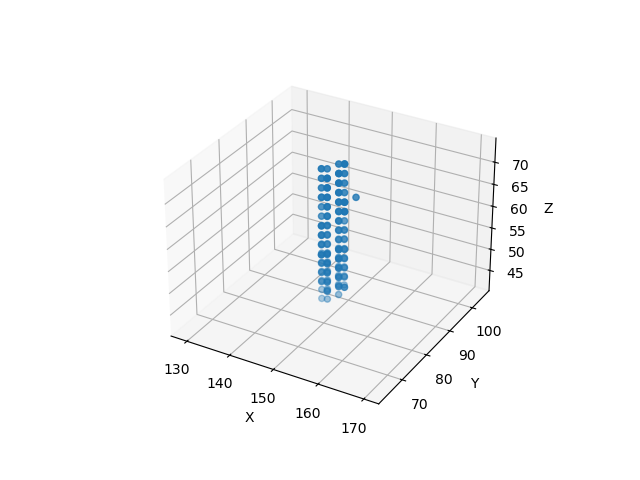

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv



fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')
ax.scatter(x,y,z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.axis('equal')

plt.show()

In [274]:
remove=[i for i in sample.event_list if i.get("type")=="remove"]

In [275]:
sorted_remove=sorted(remove,key=lambda x:x["rate"])

In [276]:
sorted_remove


[{'type': 'remove',
  'rate': 0.0031116917729914965,
  'parameters': ((142749, 147750), (147749, 147750))},
 {'type': 'remove',
  'rate': 0.0031116917729914965,
  'parameters': ((132649, 137648), (137648, 137649))},
 {'type': 'remove',
  'rate': 0.0031116917729914965,
  'parameters': ((132651, 137652), (137651, 137652))},
 {'type': 'remove',
  'rate': 0.022992465073215146,
  'parameters': ((132749, 132650), (132749, 137650))},
 {'type': 'remove',
  'rate': 0.022992465073215146,
  'parameters': ((137749, 142750), (142749, 142750))},
 {'type': 'remove',
  'rate': 0.022992465073215146,
  'parameters': ((127649, 132648), (132648, 132649))},
 {'type': 'remove',
  'rate': 0.022992465073215146,
  'parameters': ((127649, 127650), (127650, 127651))},
 {'type': 'remove',
  'rate': 0.022992465073215146,
  'parameters': ((127651, 132652), (132651, 132652))},
 {'type': 'remove',
  'rate': 0.022992465073215146,
  'parameters': ((147749, 152750), (152749, 152750))},
 {'type': 'remove',
  'rate': 0.02

In [282]:
sample.event_list

[{'type': 'add', 'rate': 0.25, 'parameters': 127748},
 {'type': 'add', 'rate': 0.25, 'parameters': 132748},
 {'type': 'add', 'rate': 0.25, 'parameters': 127750},
 {'type': 'add', 'rate': 0.25, 'parameters': 132750},
 {'type': 'add', 'rate': 0.25, 'parameters': 122648},
 {'type': 'add', 'rate': 0.0625, 'parameters': 127648},
 {'type': 'add', 'rate': 0.0625, 'parameters': 122550},
 {'type': 'add', 'rate': 0.25, 'parameters': 122650},
 {'type': 'add', 'rate': 0.0625, 'parameters': 132648},
 {'type': 'add', 'rate': 0.0625, 'parameters': 122651},
 {'type': 'add', 'rate': 0.25, 'parameters': 122749},
 {'type': 'add', 'rate': 0.25, 'parameters': 127652},
 {'type': 'add', 'rate': 0.0625, 'parameters': 132652},
 {'type': 'add', 'rate': 0.0625, 'parameters': 137648},
 {'type': 'add', 'rate': 0.0625, 'parameters': 132749},
 {'type': 'add', 'rate': 0.0625, 'parameters': 137652},
 {'type': 'add', 'rate': 0.0625, 'parameters': 142648},
 {'type': 'add', 'rate': 0.0625, 'parameters': 137749},
 {'type'

In [240]:
position=[]
for node in seed: 
    if node!=127553:
        id=latticeid24id(node)
        position.append(cartesian_from_4d(id))
position=np.array(position)
x=position[:,0]
y=position[:,1]
z=position[:,2]



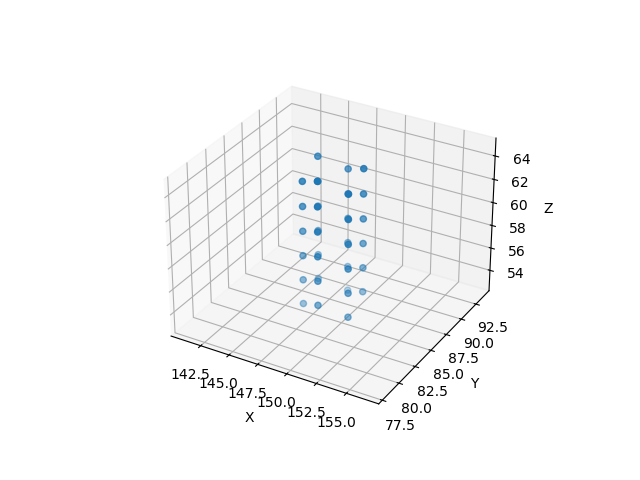

In [241]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv



fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')
ax.scatter(x,y,z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.axis('equal')

plt.show()

In [239]:
seed

[127550,
 127551,
 127552,
 127651,
 127650,
 127649,
 132550,
 132551,
 132552,
 132651,
 132650,
 132649,
 137550,
 137551,
 137552,
 137651,
 137650,
 137649,
 142550,
 142551,
 142552,
 142651,
 142650,
 142649,
 147550,
 147551,
 147552,
 147651,
 147650,
 147649,
 152550,
 152551,
 152552,
 152651,
 152650,
 152649,
 127553]